# **Laboratorio 3 - Informe**

### Grupo 4:
     - S. Calvo C.I 5.711.417-7     
     - X. Iribarnegaray C.I 5.253.705-9
     - J. Simonelli C.I 5.405.358-4

## 1. Objetivos
El objetivo de este laboratorio es:
- Implementar funciones de AgenteRL para el ambiente open-ai gymnassium
- Analizar los resultados obtenidos luego de ejecuciones del agente entrenado
- Fundamentar la elección de los hiperparámetros utilizados

### **1. Bibliotecas**

In [1]:
!pip3 install cmake gymnasium scipy numpy gymnasium[box2d] pygame==2.6.0 swig
import sys
# Tal vez tengan que ejecutar lo siguiente en sus máquinas (ubuntu 20.04)
# sudo apt-get remove swig
# sudo apt-get install swig3.0
# sudo ln -s /usr/bin/swig3.0 /usr/bin/swig
# En windows tambien puede ser necesario MSVC++
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
import json


Defaulting to user installation because normal site-packages is not writeable


## **3. Discretizando el estado**

El estado consiste de posiciones y velocidades en (x,y,theta) y en información de contacto de los pies con la superficie.

Como varios de estos son continuos, tenemos que discretizarlos para aplicar nuestro algoritmo de aprendizaje por refuerzo tabular.

In [2]:
# Cuántos bins queremos por dimensión
# Pueden considerar variar este parámetro
bins_per_dim = 20

# Estado:
# (x, y, x_vel, y_vel, theta, theta_vel, pie_izq_en_contacto, pie_derecho_en_contacto)
NUM_BINS = [bins_per_dim, bins_per_dim, bins_per_dim, bins_per_dim, bins_per_dim, bins_per_dim, 2, 2]

env = gym.make('LunarLander-v2')
env.reset()

# Tomamos los rangos del env
OBS_SPACE_HIGH = env.observation_space.high
OBS_SPACE_LOW = env.observation_space.low
OBS_SPACE_LOW[1] = 0 # Para la coordenada y (altura), no podemos ir más abajo que la zona dea aterrizae (que está en el 0, 0)

# Los bins para cada dimensión
bins = [
    np.linspace(OBS_SPACE_LOW[i], OBS_SPACE_HIGH[i], NUM_BINS[i] - 1)
    for i in range(len(NUM_BINS) - 2) # last two are binary
]
# Se recomienda observar los bins para entender su estructura
# print ("Bins: ", bins)

def discretize_state(state, bins):
    """Discretize the continuous state into a tuple of discrete indices."""
    state_disc = list()
    for i in range(len(state)):
        if i >= len(bins):  # For binary features (leg contacts)
            state_disc.append(int(state[i]))
        else:
            state_disc.append(
                np.digitize(state[i], bins[i])
            )
    return tuple(state_disc)

## **4. Agentes y la interacción con el entorno**

Definimos una interfaz para nuestro agente:

In [3]:
class Agente:
    def elegir_accion(self, estado, max_accion, explorar = True) -> int:
        """Elegir la accion a tomar en el estado actual y el espacio de acciones
            - estado_anterior: el estado desde que se empezó
            - estado_siguiente: el estado al que se llegó
            - accion: la acción que llevo al agente desde estado_anterior a estado_siguiente
            - recompensa: la recompensa recibida en la transicion
            - terminado: si el episodio terminó
        """
        pass

    def aprender(self, estado_anterior, estado_siguiente, accion, recompensa, terminado):
        """Aprender a partir de la tupla 
            - estado_anterior: el estado desde que se empezó
            - estado_siguiente: el estado al que se llegó
            - accion: la acción que llevo al agente desde estado_anterior a estado_siguiente
            - recompensa: la recompensa recibida en la transicion
            - terminado: si el episodio terminó en esta transición
        """
        pass

    def fin_episodio(self):
        """Actualizar estructuras al final de un episodio"""
        pass

Luego definimos la función `ejecutar_episodio` para ejecutar un episodio con el agente AgenteRL:

In [4]:
def ejecutar_episodio(agente, aprender, render, max_iteraciones=500):
    if (render):
        entorno = gym.make('LunarLander-v2', render_mode='human').env
    else: 
        entorno = gym.make('LunarLander-v2').env
    
    iteraciones = 0
    recompensa_total = 0

    termino = False
    truncado = False
    estado_anterior, info = entorno.reset()
    while iteraciones < max_iteraciones and not termino and not truncado:
        if render:
            entorno.render()
        # Le pedimos al agente que elija entre las posibles acciones (0..entorno.action_space.n)
        accion = agente.elegir_accion(estado_anterior, entorno.action_space.n, aprender)
        # Realizamos la accion
        estado_siguiente, recompensa, termino, truncado, info = entorno.step(accion)
        # Le informamos al agente para que aprenda
        if (aprender):
            agente.aprender(estado_anterior, estado_siguiente, accion, recompensa, termino)

        estado_anterior = estado_siguiente
        iteraciones += 1
        recompensa_total += recompensa
    if (aprender):
        agente.fin_episodio(recompensa_total)
    entorno.close()
    return recompensa_total

### **5. Programando un agente que aprende**

A continuación implementamos el agente:

In [5]:
import numpy as np
import random

class AgenteRL(Agente):
    # Pueden agregar parámetros al constructor
    def __init__(self, states, actions, gamma, start_epsilon, end_epsilon, num_episodes) -> None:
        super().__init__()
        self.Q = np.zeros((states,actions))
        self.visits = np.zeros((states, actions))
        self.gamma = gamma
        self.epsilon = start_epsilon
        self.end_epsilon = end_epsilon
        self.decay_factor = (end_epsilon/start_epsilon)**(1/num_episodes) # No usado 
        self.recompensa_maxima = -np.inf
        
        
    def discretized_state_to_index(self, discretized_state):
        return discretized_state[0] * 12800000 + discretized_state[1] * 640000 + discretized_state[2] * 32000 + \
           discretized_state[3] * 1600 + discretized_state[4] * 80 + discretized_state[5] * 4 + \
           discretized_state[6] * 2 + discretized_state[7]
           
    def actualizar_epsilon(self):
        return max(self.end_epsilon, self.epsilon * self.decay_factor)

    
    def elegir_accion(self, estado, max_accion, explorar = True) -> int:
        discretized_state = discretize_state(estado, bins)
        row = self.discretized_state_to_index(discretized_state)
        
        if explorar and np.random.random() < self.epsilon:
            return random.randrange(max_accion)  # Exploración
        else:
            return np.argmax(self.Q[row])  # Explotación
    
    def aprender(self, estado_anterior, estado_siguiente, accion, recompensa, terminado):
        discretized_state_anterior = discretize_state(estado_anterior, bins)
        discretized_state_siguiente = discretize_state(estado_siguiente, bins)
        
        row_anterior = self.discretized_state_to_index(discretized_state_anterior)
        self.visits[row_anterior, accion] += 1
        alpha_n = 1 / self.visits[row_anterior, accion]

        row_siguiente = self.discretized_state_to_index(discretized_state_siguiente)
        
        # Fórmula de actualización de Q-learning
        if not terminado:
            self.Q[row_anterior][accion] = (1 - alpha_n) * self.Q[row_anterior][accion] + alpha_n * (recompensa + self.gamma * np.max(self.Q[row_siguiente]))
        else:
            # Si el episodio terminó, no hay valor de futuro
            self.Q[row_anterior][accion] = (1 - alpha_n) * self.Q[row_anterior][accion] + alpha_n * (recompensa)

    def fin_episodio(self, recompensa_total):
        if recompensa_total > self.recompensa_maxima:
            self.recompensa_maxima = recompensa_total
            self.epsilon *= 0.9
        self.epsilon = max(self.end_epsilon, self.epsilon)
        

## Explicar implementación

Y ejecutar con el muchos episodios:

In [6]:
# Nota: hay que transformar esta celda en código para ejecutar (Esc + y)
# Advertencia: este bloque es un loop infinito si el agente se deja sin implementar
entorno = gym.make('LunarLander-v2').env
episodios = 100_000
agente = AgenteRL(np.prod(NUM_BINS),entorno.action_space.n,1,start_epsilon=1,end_epsilon=0.01,num_episodes=episodios)
exitos = 0
recompensa_acumulada_intervalo = []
exitos_intervalo_array = []
exitos_intervalo = 0
recompensas = []
epsilons = []
iteraciones = []
intervalos = 1000
for i in range(episodios):
    recompensa = ejecutar_episodio(agente, aprender=True, render=False)
    if (recompensa >= 200):
        exitos += 1
        exitos_intervalo += 1
    recompensa_acumulada_intervalo += [recompensa]
    if (i % intervalos == 0):
        print('Episodio', i,'- Promedio de últimas', intervalos ,'iteraciones: ', np.mean(recompensa_acumulada_intervalo),'- Epsilon:', agente.epsilon)
        recompensas.append(np.mean(recompensa_acumulada_intervalo))
        epsilons.append(agente.epsilon)
        exitos_intervalo_array.append(exitos_intervalo)
        exitos_intervalo = 0
        recompensa_acumulada_intervalo = []

Episodio 0 - Promedio de últimas 1000 iteraciones:  -303.30171589892564 - Epsilon: 0.9
Episodio 1000 - Promedio de últimas 1000 iteraciones:  -150.11313731978046 - Epsilon: 0.31381059609000017
Episodio 2000 - Promedio de últimas 1000 iteraciones:  -133.53895291800018 - Epsilon: 0.28242953648100017
Episodio 3000 - Promedio de últimas 1000 iteraciones:  -130.32496689183841 - Epsilon: 0.28242953648100017
Episodio 4000 - Promedio de últimas 1000 iteraciones:  -118.89704376616696 - Epsilon: 0.28242953648100017
Episodio 5000 - Promedio de últimas 1000 iteraciones:  -115.47265121853644 - Epsilon: 0.28242953648100017
Episodio 6000 - Promedio de últimas 1000 iteraciones:  -108.87240315570016 - Epsilon: 0.28242953648100017
Episodio 7000 - Promedio de últimas 1000 iteraciones:  -113.56705522959909 - Epsilon: 0.28242953648100017
Episodio 8000 - Promedio de últimas 1000 iteraciones:  -110.814554349009 - Epsilon: 0.28242953648100017
Episodio 9000 - Promedio de últimas 1000 iteraciones:  -105.8546742

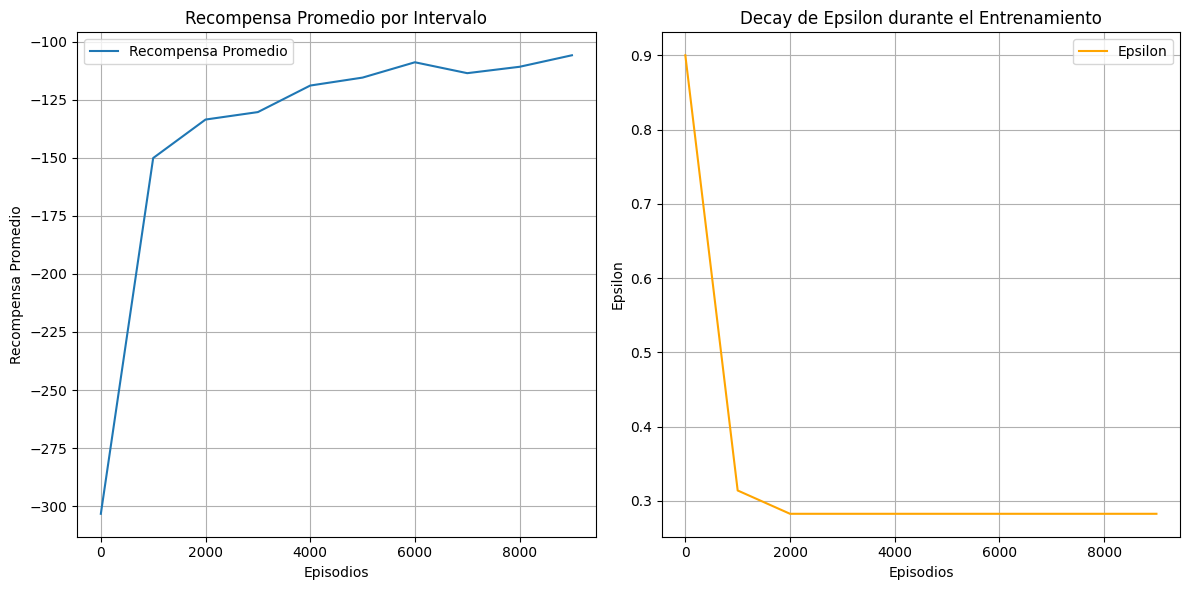

In [7]:

episodios_plot = range(0, episodios, intervalos)
# Crear la figura y los ejes
plt.figure(figsize=(12, 6))

# Primera gráfica: Recompensas en función de episodios
plt.subplot(1, 2, 1)
plt.plot(episodios_plot, recompensas, label='Recompensa Promedio')
plt.xlabel('Episodios')
plt.ylabel('Recompensa Promedio')
plt.title('Recompensa Promedio por Intervalo')
plt.grid(True)
plt.legend()

# Segunda gráfica: Epsilon en función de episodios
plt.subplot(1, 2, 2)
plt.plot(episodios_plot, epsilons, label='Epsilon', color='orange')
plt.xlabel('Episodios')
plt.ylabel('Epsilon')
plt.title('Decay de Epsilon durante el Entrenamiento')
plt.grid(True)
plt.legend()

# Mostrar las gráficas
plt.tight_layout()  # Ajusta automáticamente los espacios entre subplots
plt.show()

Analizar los resultados de la ejecución anterior, incluyendo:
 * Un análisis de los parámetros utilizados en el algoritmo (aprendizaje, política de exploración)
 * Un análisis de algunos 'cortes' de la matriz Q y la política (p.e. qué hace la nave cuando está cayendo rápidamente hacia abajo, sin rotación)
    * Definir los estados (filas) de la matriz Q que cumplan con las condiciones planteadas (caida libre sin rotación, hovering, quieto en el piso)
 * Un análisis de la evolución de la recompensa promedio
 * Un análisis de los casos de éxito
 * Un análisis de los casos en el que el agente falla
 * Qué limitante del agente de RL les parece que afecta más negativamente su desempeño. Cómo lo mejorarían? 

In [9]:
#ejecutar_episodio(agente, aprender=False, render=True, max_iteraciones=500)
#print()
exitos = 0
num_episodios = 1000
recompensa_episodios = []
for i in range(num_episodios):
    recompensa = ejecutar_episodio(agente, aprender=False, render=False)
    # Los episodios se consideran exitosos si se obutvo 200 o más de recompensa total
    if (recompensa >= 200):
        exitos += 1
        print('it', i, ' Exito: ',recompensa)
    # print('it', i, ' Recompensa: ',recompensa)
    recompensa_episodios += [recompensa]
print(f"Tasa de éxito: {exitos / num_episodios}. Se obtuvo {np.mean(recompensa_episodios)} de recompensa, en promedio")


it 25  Exito:  269.75262354815084
it 463  Exito:  244.78627384739912
it 699  Exito:  278.69249739900437
Tasa de éxito: 0.003. Se obtuvo -149.55640052054503 de recompensa, en promedio
